In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import glob




def loadFile(name):
    data=pd.read_csv(name,sep="\t")
    data["H"]=np.round(data["B_extx (T)"]*10000/(np.sqrt(2)/2))
    data["m_full"]=(data["m_fullx (A/m)"]+data["m_fully (A/m)"])/np.sqrt(2)
    data["m"]=data["m_full"]/np.max(np.abs(data["m_full"]))

    try: 
        data["hIsland_my"]=data["m_full.region1y (A/m)"]/np.max(np.sqrt(data["m_full.region1y (A/m)"]**2+data["m_full.region1x (A/m)"]**2))
    except Exception:
        pass
    

    data=data.drop(columns=["# t (s)",\
    "mz ()","mx ()", "my ()",\
    "B_extx (T)", "B_exty (T)","B_extz (T)",\
    "m_fullz (A/m)","m_fullx (A/m)","m_fully (A/m)",\
    "m_full.region1x (A/m)","m_full.region1y (A/m)","m_full.region1z (A/m)",\
    "m_full.region2x (A/m)","m_full.region2y (A/m)","m_full.region2z (A/m)"])

    try:
        data.attrs["Hc"]=np.average(np.abs(data[np.sign(data["m"]).diff() != 0]["H"].iloc[1:]))
        data.attrs["Br"]=np.average(np.abs(data[np.sign(data["H"]).diff() != 0]["m"].iloc[1:]))
    except Exception:
        pass


    return data

def arrayToColors(data):

    data=(data-np.min(data))/(np.max(data)-np.min(data))
    return mpl.cm.plasma(np.array(data))

def getData():
    data=[]
    
    files=glob.glob("alternateLengthData/*")
    badFiles=[]

    for name in files:
        pointiness,temp=name.split("spacing")
        spacing,length=temp.split("length")
        pointiness=float(pointiness[30:-1])
        spacing=float(spacing[:-1])
        length=float(length[:-4])

        try:
            thisData=loadFile(name+"/table.txt")
            thisData.attrs["pointiness"]=pointiness
        
            thisData.attrs["spacing"]=spacing
            thisData.attrs["length"]=length
            data.append(thisData)
        except Exception as e:
            badFiles.append(name)
            continue


    print(f"Could not load {len(badFiles)}/{len(files)} file")
    return data

def getClosestPlot(spacing,pointiness,length):
    minDist=None
    bestRun=None
    for run in data:
        dist=abs(run.attrs["spacing"]-spacing)+abs(run.attrs["pointiness"]-pointiness)+abs(run.attrs["length"]-length)
        if minDist is None or dist<minDist:
            minDist=dist
            bestRun=run
    return bestRun


def getPossibleVals(data):
    pointinessVals=[]
    spacingVals=[]
    lengthVals=[]
    for i in data:
        if i.attrs["pointiness"] not in pointinessVals: pointinessVals.append(i.attrs["pointiness"])
        if i.attrs["length"] not in lengthVals: lengthVals.append(i.attrs["length"])
        if i.attrs["spacing"] not in spacingVals: spacingVals.append(i.attrs["spacing"])

    pointinessVals.sort()
    spacingVals.sort()
    lengthVals.sort()

    return pointinessVals, spacingVals, lengthVals



data=getData()

pointinessVals, spacingVals, lengthVals = getPossibleVals(data)


C:\Users\Schif\AppData\Roaming\Python\Python310\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Schif\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Schif\AppData\Roaming\Python\Python310\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Schif\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Could not load 0/615 file


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2.8e-07, 3.0000000000000004e-07, 3.2e-07, 3.4000000000000003e-07, 3.6000000000000005e-07, 3.8e-07, 4.0000000000000003e-07, 4.2e-07, 4.4e-07, 5.12e-07, 7.680000000000001e-07, 1.024e-06]


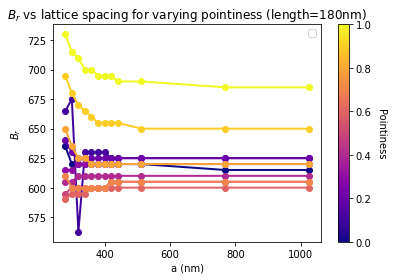

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


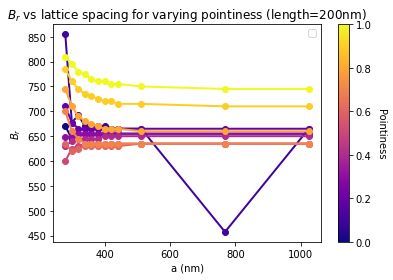

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


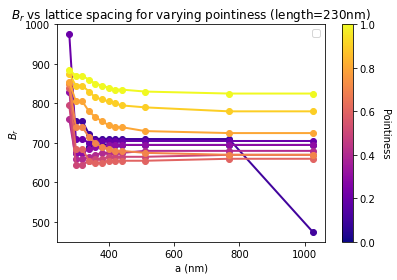

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


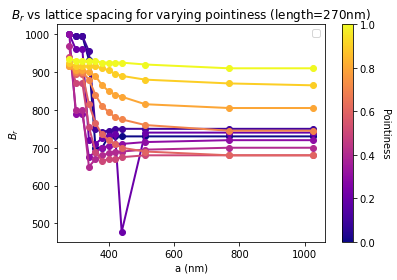

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


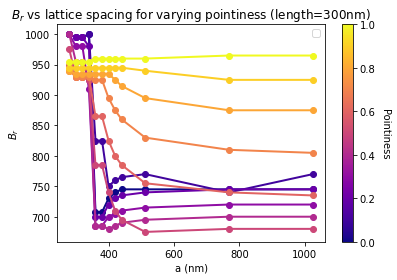

In [6]:

def makePlot(lengthVal):
    colors=plt.cm.plasma(pointinessVals)
    for i,pointiness in enumerate(pointinessVals):
        Hc=[]
        spacings=[]
        for spacing in spacingVals:
            thisRun=getClosestPlot(spacing,pointiness,lengthVal)
            Hc.append(thisRun.attrs["Br"])
            spacings.append(spacing*1e9)
        plt.plot(spacings,Hc,"o-",color=colors[i],linewidth=2)
        
    cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma"))
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Pointiness', rotation=270)
    plt.title(f"$B_r$ vs lattice spacing for varying pointiness (length={round(lengthVal*1e9)}nm)")
    plt.xlabel("a (nm)")
    plt.ylabel("$B_r$")


    plt.legend()
    plt.show()
print(spacingVals)
for lengthVal in lengthVals:
    makePlot(lengthVal)